In [467]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind
from functools import reduce
import cufflinks as cf
import plotly
from statsmodels.tsa.seasonal import STL
import sesd
import plotly.offline as py
import plotly.graph_objs as go
import seaborn as sns; sns.set(color_codes=True)
cf.go_offline() # required to use plotly offline (no account required).
py.init_notebook_mode() # graphs charts inline (IPython).

ModuleNotFoundError: No module named 'sesd'

In [469]:
data = pd.read_csv('/content/drive/My Drive/GS_self_study/executiontest.csv')
# given constant gmv;
gmv = 1e8

In [ ]:
data.head()

In [ ]:
data_groupby_exid = data.groupby('exchange_id')

# Data Feed Missing

## exchange 12

In [7]:
data_groupby_exid['trading_date'].count().sort_values(ascending=False)
exchange_ids = [13, 8, 7, 6, 5, 4, 3, 2, 1]
# so 13, 9, 7, 6, 5, 4, 3, 2, 1 have same count of trading dates

In [8]:
# 12 is weird. as it uses same start date and end date but have different counts of trades
dates_12 = data[data['exchange_id']==12]['trading_date']
dates_13 = data[data['exchange_id']==13]['trading_date']

In [9]:
set(dates_13.values).difference(set(dates_12.values))
# anomaly 001: exchange 12 data feed missing

{'2019-07-04',
 '2019-07-05',
 '2019-07-08',
 '2019-07-09',
 '2019-07-10',
 '2019-07-11',
 '2019-07-12',
 '2019-07-15',
 '2019-07-16',
 '2019-07-17',
 '2019-07-18',
 '2019-07-19',
 '2019-07-22',
 '2019-07-23',
 '2019-07-24',
 '2019-07-25',
 '2019-07-26',
 '2019-07-29',
 '2019-07-30',
 '2019-07-31'}

## traded_volume!=0; pnl = 0

In [10]:
data[np.logical_and(data['traded_volume']!=0, data['pnl']==0)]

,trading_date,exchange_id,traded_volume,pnl
2724,2018-12-12,6,366,0.0
4432,2019-02-11,10,6,0.0


In [11]:
data[np.logical_and(data['traded_volume']!=0, data['pnl']==0)]['trading_date'].value_counts()

2018-12-12    1
2019-02-11    1
Name: trading_date, dtype: int64

# Data being outlier

## types of trades

In [12]:
# select a subgroup of exchange that share the same dates

data1 = data[data['exchange_id'].isin(exchange_ids)]

In [13]:
data1_both_larger_0 = data1[np.logical_and(data['traded_volume']>0, data['pnl']>0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [14]:
data1_only_volume_eq_0 = data1[np.logical_and(data['traded_volume']==0, data['pnl']>0)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [15]:
data1_both_larger_0

,trading_date,exchange_id,traded_volume,pnl
1,2018-08-03,1,899,79136.327180
6,2018-08-10,1,844,171481.601600
9,2018-08-15,1,608,13167.277770
10,2018-08-16,1,833,203658.796100
11,2018-08-17,1,877,36270.133870
...,...,...,...,...
5907,2020-07-28,13,2391,57470.850320
5908,2020-07-29,13,1664,56994.196340
5909,2020-07-30,13,1897,326.889691
5911,2020-08-03,13,2991,82124.726680


In [16]:
ttest_ind(data1_both_larger_0['traded_volume'],data1_only_volume_eq_0['traded_volume'], equal_var = False)

Ttest_indResult(statistic=37.09773242806845, pvalue=9.978059370013202e-234)

In [17]:
ttest_ind(data1_both_larger_0['pnl'],data1_only_volume_eq_0['pnl'], equal_var = False)

Ttest_indResult(statistic=2.5456988727972822, pvalue=0.017003514927823184)

## group A

In [18]:
data1_both_larger_0.set_index('trading_date', inplace=True)

In [19]:
cross_sectional_dfs = []
for i in exchange_ids:
    tmp_df = data1_both_larger_0[data1_both_larger_0['exchange_id'] == i][['traded_volume', 'pnl']]
    tmp_df.columns = list(map(lambda x: f"{x}_{i}", tmp_df.columns))
    
    cross_sectional_dfs.append(tmp_df)
    
final_df = pd.DataFrame(index= pd.date_range(min([_.index.tolist()[0] for _ in cross_sectional_dfs]),
                                            max([_.index.tolist()[-1] for _ in cross_sectional_dfs])))

for df in cross_sectional_dfs:
    

    final_df = final_df.join(df)
   

In [20]:
final_df

,traded_volume_13,pnl_13,traded_volume_8,pnl_8,traded_volume_7,pnl_7,traded_volume_6,pnl_6,traded_volume_5,pnl_5,traded_volume_4,pnl_4,traded_volume_3,pnl_3,traded_volume_2,pnl_2,traded_volume_1,pnl_1
2018-08-02,NaN,NaN,NaN,NaN,NaN,NaN,286.0,17724.08581,NaN,NaN,1273.0,27721.7798,6.0,8062.965560,2736.0,4.016507e+05,NaN,NaN
2018-08-03,NaN,NaN,NaN,NaN,2302.0,156647.4499,420.0,14549.13182,459.0,3430.97447,NaN,NaN,7.0,9771.498168,NaN,NaN,899.0,79136.327180
2018-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-08-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2166.0,111372.87170,NaN,NaN,9.0,9573.402727,2167.0,3.463943e+04,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-03,2991.0,82124.72668,178.0,36624.22976,1166.0,104327.6423,NaN,NaN,NaN,NaN,NaN,NaN,3.0,45207.641890,1956.0,2.342000e+05,2678.0,11764.353290
2020-08-04,2001.0,413660.43340,NaN,NaN,1401.0,115249.7151,NaN,NaN,NaN,NaN,NaN,NaN,7.0,1295.368206,NaN,NaN,2069.0,8540.365366
2020-08-05,NaN,NaN,NaN,NaN,NaN,NaN,359.0,88061.89537,NaN,NaN,NaN,NaN,3.0,32545.122920,1514.0,1.078036e+06,NaN,NaN


In [21]:
vol_cols = [_ for _ in final_df.columns if _.startswith('traded')]
pnl_cols = [_ for _ in final_df.columns if _.startswith('pnl')]


In [22]:
final_df[vol_cols].iplot(kind='bar')

In [23]:
final_df[pnl_cols].iplot(kind='bar')

## Exchange 2

In [24]:
ex_list = [0]*len(exchange_ids)
for i in range(len(exchange_ids)):
    ex_list[i] = data1_both_larger_0[data1_both_larger_0['exchange_id'] == i]

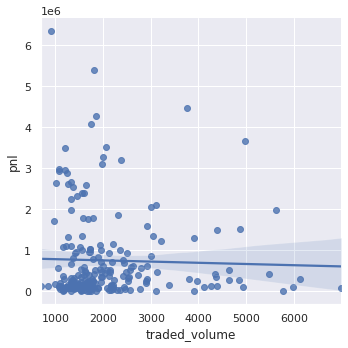

In [25]:
# linear fit plot understanding the relationship between pnl and desk
sns.lmplot(x="traded_volume", y="pnl",
               data=data1_both_larger_0[data1_both_larger_0['exchange_id'] == 2])

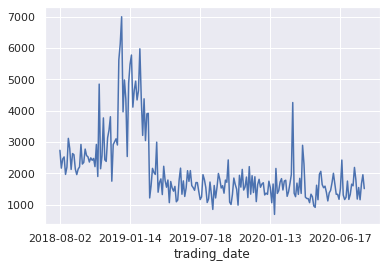

In [26]:
ex_list[2]['traded_volume'].plot()

In [27]:
ex_list[2]['pnl'].iplot()

In [28]:
# rolling window
burn_in = 30
threshold = []
# alternatively could use pd.rolling
for i in range(len(ex_list[2])-burn_in ):
    data = ex_list[2]['traded_volume'][i: i + burn_in]
    data = data[data<np.percentile(data, 98)]
    median = np.nanmedian(data)
    std = np.nanstd(data, ddof=1)
    threshold.append(median +3*std)
    
ex_list[2]['traded_threshold'] = ([0]*burn_in).__add__(threshold)

In [29]:
ex_list[2][['traded_volume', 'traded_threshold']].iplot()

In [54]:
outliers_indices = sesd.seasonal_esd(ex_list[2]['pnl'], periodicity=60, hybrid=True, max_anomalies=20)

In [55]:
for idx in outliers_indices:
    print(f"Anomaly index: {idx}, anomaly value: { ex_list[2]['pnl'].iloc[idx] }")

Anomaly index: 31, anomaly value: 4473581.532
Anomaly index: 113, anomaly value: 3285625.296
Anomaly index: 97, anomaly value: 8826.523045
Anomaly index: 112, anomaly value: 2392822.473
Anomaly index: 121, anomaly value: 2939040.349
Anomaly index: 62, anomaly value: 8933.559079999999
Anomaly index: 91, anomaly value: 81958.98966
Anomaly index: 126, anomaly value: 171477.7907
Anomaly index: 111, anomaly value: 111887.0158
Anomaly index: 125, anomaly value: 452287.124
Anomaly index: 93, anomaly value: 514209.8709
Anomaly index: 127, anomaly value: 190441.2169
Anomaly index: 133, anomaly value: 76162.21082000001
Anomaly index: 147, anomaly value: 76569.2028
Anomaly index: 65, anomaly value: 395819.9994
Anomaly index: 122, anomaly value: 2650277.307
Anomaly index: 106, anomaly value: 300373.8473
Anomaly index: 129, anomaly value: 1338337.134
Anomaly index: 109, anomaly value: 130390.0397
Anomaly index: 104, anomaly value: 1016007.608


In [59]:
ex_list[2]['is_anomaly'] = 0
for i, row in enumerate(ex_list[2]):
  if i in outliers_indices:
    ex_list[2].loc[i, 'is_anomaly'] = 1

In [64]:
ex_list[2]

,exchange_id,traded_volume,pnl,traded_threshold,is_anomaly
trading_date,,,,,
2018-08-02,2,2736,4.016507e+05,0.000000,0
2018-08-06,2,2167,3.463943e+04,0.000000,0
2018-08-08,2,2461,5.702858e+04,0.000000,0
2018-08-10,2,2525,2.493420e+05,0.000000,0
2018-08-13,2,1967,3.602250e+05,0.000000,0
...,...,...,...,...,...
2020-07-27,2,1549,1.474469e+05,2419.513337,0
2020-07-28,2,1159,1.077783e+06,2417.759997,0
2020-07-30,2,1668,1.449730e+05,2417.759997,0
